### Cab-Driver Agent Reinforcement Learning

### PROBLEM STATEMENT:

-  Build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.

- Taking long-term profit as the goal, you propose a method based on reinforcement learning to optimize taxi driving strategies for profit maximization


### GOAL:

- Create the environment and an RL agent that learns to choose the best request using DQN

- Demonstrate convergance of Q-values



### ARCHITECTURE FOLLOWED

<h3><b>As per the diagram, Architecture 2 :</b>Using only State as Input</h3>
<br>

<center><img src="arch.png" height="50%" width="50%"/></center>

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import time

# for plotting graphs
import matplotlib.pyplot as plt

# taqadum for progressbar
from tqdm import tqdm

# Import the environment
from Env import CabDriver

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Defining Time Matrix

#### Tracking the state-action pairs for checking convergence


In [3]:
# define a method to iniitalize tracking status
def init_tracking_states():
    state_action_pair = [
                        ((4,16,4),(2,1)),
                        ((4,0,2),(3,2)),
                        ((0,0,0),(0,2)),
                        ((3,18,5),(3,4))]
    for state, action in state_action_pair:
        if state not in states_tracked:
            states_tracked[state] = dict()
        states_tracked[state][action] = list()

In [4]:

states_tracked = dict()

# initialize tracking status
init_tracking_states()

# print tracked status
states_tracked

{(4, 16, 4): {(2, 1): []},
 (4, 0, 2): {(3, 2): []},
 (0, 0, 0): {(0, 2): []},
 (3, 18, 5): {(3, 4): []}}

In [5]:
# define a method to updated tracking status,which gets called after every 25 episodes
def update_tracking_states():
    for state_val in states_tracked.keys():
        # encode the state
        encoded_state = np.array(env.state_encod_arch1(state_val)).reshape(1,36)
        
        # Predict the q-values for the encoded state
        q_pred_val = agent.model.predict(encoded_state)
        
        # iterate over the initialized tracked_status amd get the avaiable action space index
        for action_val in states_tracked[state_val].keys():
            for index, a in enumerate(env.action_space):
                if action_val == a:
                    action_index = index
                    break
            
            # Get the q-value for the action
            q_val = q_pred_val[0][action_index]
            
            # append the selected action to the state-action pair
            states_tracked[state_val][action_val].append(q_val)

In [6]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Initialize hyperparameters for DQN Agent
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005 
        self.epsilon_min = 0.00001
        self.batch_size = 32  
        self.epsilon = 1
        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Input Layer       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        
        # hidden Layer 1
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        # Output Layer
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        # compile the model using Adam Optimizer and MSE loss function
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        
        print(model.summary)
        return model



    def get_action(self, state):
        
    # We are using epsilon-greedy policy to get the desired action
          
        # get the possible list of ride request for the given state
        requests_index, action_vals = env.requests(state)
        
        random_val = np.random.rand()        
        # using Epsilon-greedy approach 
        if random_val > self.epsilon:
            # exploitation
            # : Choose the action with the highest Q(S,A)
            
            # encode the state on arch2
            encoded_state = np.array(env.state_encod_arch1(state)).reshape(1,m+t+d)
            
            # using the model to Predict the q-values for the give state
            predicted_q_vals = self.model.predict(encoded_state)
            
            # Get only the possible q values for the given actions
            filter_q_vals = [predicted_q_vals[0][i] for i in requests_index]
            
            # Get the max q-value formt he filtered list
            max_q_val_index = np.argmax(np.array(filter_q_vals))
            
            # get the ation for the selected q-value
            select_action = action_vals[max_q_val_index]
        else:
            # exploration
            # : Chosse a random action from all possible actions
            select_action = random.choice(action_vals)
        
        # Get the index of the selected action from action_space
        for i, action in enumerate(env.action_space):
            if select_action == action:
                select_action_index = i
                break
        
        return select_action_index, select_action
        
        
    def append_sample(self, state, action, reward, next_state,is_terminal):
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, is_terminal))
    
    
    
    # build the model data as batch samples from memory
    def train_model(self,time_step):

        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            actions_list, rewards_list, is_terminal = [], [], []
            
            # get the values of update_input, update_output, action
            # is_terminal and rewards from mini_batch on each iteration
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal = mini_batch[i]
                            
                update_input[i] = env.state_encod_arch1(state)
                update_output[i] = env.state_encod_arch1(next_state)
                
                actions_list.append(action)
                rewards_list.append(reward)
                is_terminal.append(terminal)
                               
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
                
            # 2. Get the target for the Q-network
            target_q_value = self.model.predict(update_output)

            #3. Updating the 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if is_terminal[i]:
                    target[i][actions_list[i]] = rewards_list[i]
                else:
                    target[i][actions_list[i]] = rewards_list[i] + self.discount_factor * np.max(target_q_value[i])

                 
            # 4. Lets Fit the model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save(self, name):
        self.model.save_weights(name)

In [8]:
# Initialize the model training parameters
Episodes = 500

# max_total_time is number of days in month * number of hours per day ( 30 * 24 )
max_time_per_episode = 720

# Invoke Env class
env = CabDriver()

# number of cities, time per day and days in a week
m, t, d = 5, 24, 7

# initialize the state size
state_size = m + t + d

# initialize the action size
action_size = m * (m-1) + 1

# Call the DQN agent
agent = DQNAgent(action_size=action_size, state_size=state_size)

# declare useful metric for tracking
rides_count_per_episode, reward_val_per_episode ,time_taken_per_episode,epsilon = [],[],[],[]


<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fdc683d93d0>>


/home/amirtharajanpks/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


### DQN block

In [9]:
start_time = time.time()

for episode in tqdm(range(Episodes)):

    # Reset the environment for next episode
    action_space, state_space, state = env.reset()
    
    # initialize variables for tracking for each episode
    is_terminal_state = False
    consumed_time = 0
    accumulated_reward = 0
    rides_count = 0   
    
    # build and train the model until it reaches terminal state
    while not is_terminal_state:
        
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action_index, action = agent.get_action(state)
        
        # 2. Evaluate the reward and next state
        next_stat_val, reward_val, time_taken = env.next_state_func(state, action, Time_matrix)
        
        # update the duration and reward for each iteration
        consumed_time += time_taken
        accumulated_reward += reward_val
        
        # set is_terminal_state to true for the episode
        # once the cab has crossed 720 hrs of travel
        if consumed_time >= max_time_per_episode:
            is_terminal_state = True
            
        # 3. Append the experience to the memory
        agent.append_sample(state, action_index, reward_val, next_stat_val, is_terminal_state)
        
        # 4. Train the model every 50 time_steps
        if(rides_count % 50 == 0):
            agent.train_model(rides_count)
        
        # update the current state and increment the ride count
        state = next_stat_val
        rides_count += 1
        
    # 5. Keep a track of rewards, Q-values, loss for every 25 episodes
    if episode % 25 == 0:
        rides_count_per_episode.append(rides_count)
        reward_val_per_episode.append(accumulated_reward)
        time_taken_per_episode.append(consumed_time)
        update_tracking_states()

    # decay in epsilon after each episode
    agent.epsilon =agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(agent.epsilon_decay*episode)
    epsilon.append(agent.epsilon)

    # print and save the tracked states for every 1000 episodes   
    if episode % 100 == 0 or episode == 499:
        print("Episode:{} Rides:{} Reward:{} Duration of Episode:{}" \
              .format(episode, rides_count, accumulated_reward, consumed_time))
        elapsed_time = time.time() - start_time
        print("Time taken to run %s episodes is : %s" %(str(episode),str(elapsed_time)))
        save_obj(states_tracked,'States_tracked')   
        agent.save(f'Model-{episode}.h5')     

#agent.save(name="model_weight.pkl")
elapsed_time = time.time() - start_time
print("Elapsed time :", elapsed_time)
        

  0%|          | 2/500 [00:01<04:13,  1.97it/s]

Episode:0 Rides:164 Reward:-108 Duration of Episode:720
Time taken to run 0 episodes is : 0.9978373050689697


 20%|██        | 101/500 [00:24<02:02,  3.25it/s]

Episode:100 Rides:130 Reward:295 Duration of Episode:724
Time taken to run 100 episodes is : 24.312487602233887


 40%|████      | 201/500 [00:59<02:07,  2.34it/s]

Episode:200 Rides:134 Reward:0 Duration of Episode:729
Time taken to run 200 episodes is : 59.93341851234436


 60%|██████    | 301/500 [01:47<02:02,  1.63it/s]

Episode:300 Rides:159 Reward:-104 Duration of Episode:721
Time taken to run 300 episodes is : 107.30620431900024


 80%|████████  | 401/500 [02:46<01:07,  1.47it/s]

Episode:400 Rides:127 Reward:-203 Duration of Episode:721
Time taken to run 400 episodes is : 166.10883402824402


100%|██████████| 500/500 [03:52<00:00,  2.15it/s]

Episode:499 Rides:138 Reward:-302 Duration of Episode:721
Time taken to run 499 episodes is : 232.82506775856018
Elapsed time : 232.83272004127502


Lets preview the average rewards for the last 500 episodes, as we are saving reward per 25 episodes, so the last 20 entries will correspond to last 500 episodes

In [10]:
np.mean(reward_val_per_episode[-20:])

-34.95

In [11]:
# let look at the maximum reward obtained by the cab
np.max(reward_val_per_episode)

324

### Tracking Convergence

In [12]:
# assign sample state action pair for plotting tracking convergance
states_tracked_plotting = [
                        ((4,16,4),(2,1)),
                        ((4,0,2),(3,2)),
                        ((0,0,0),(0,2)),
                        ((3,18,5),(3,4))]

In [13]:
# plot a graph for state-action pair and their q-values
def convergence_plot(state_val, action_val, axes_plt):

    # get q-value for state action-pair
    tracked_q_vals = states_tracked[state_val][action_val]
    
    # get the total number of episodes
    no_of_tracked_episodes = len(tracked_q_vals)
    
    # plot the graph for sta-action adn q-values
    axes_plt.plot(range(0, no_of_tracked_episodes), tracked_q_vals)
     
    # set labels, title and legend
    axes_plt.set(ylabel="Q_value",xlabel="Number of Episode x 25",title="State : {} - Action : {}".format(state_val, action_val));
    plt.legend(["Q-value"], loc="lower right");

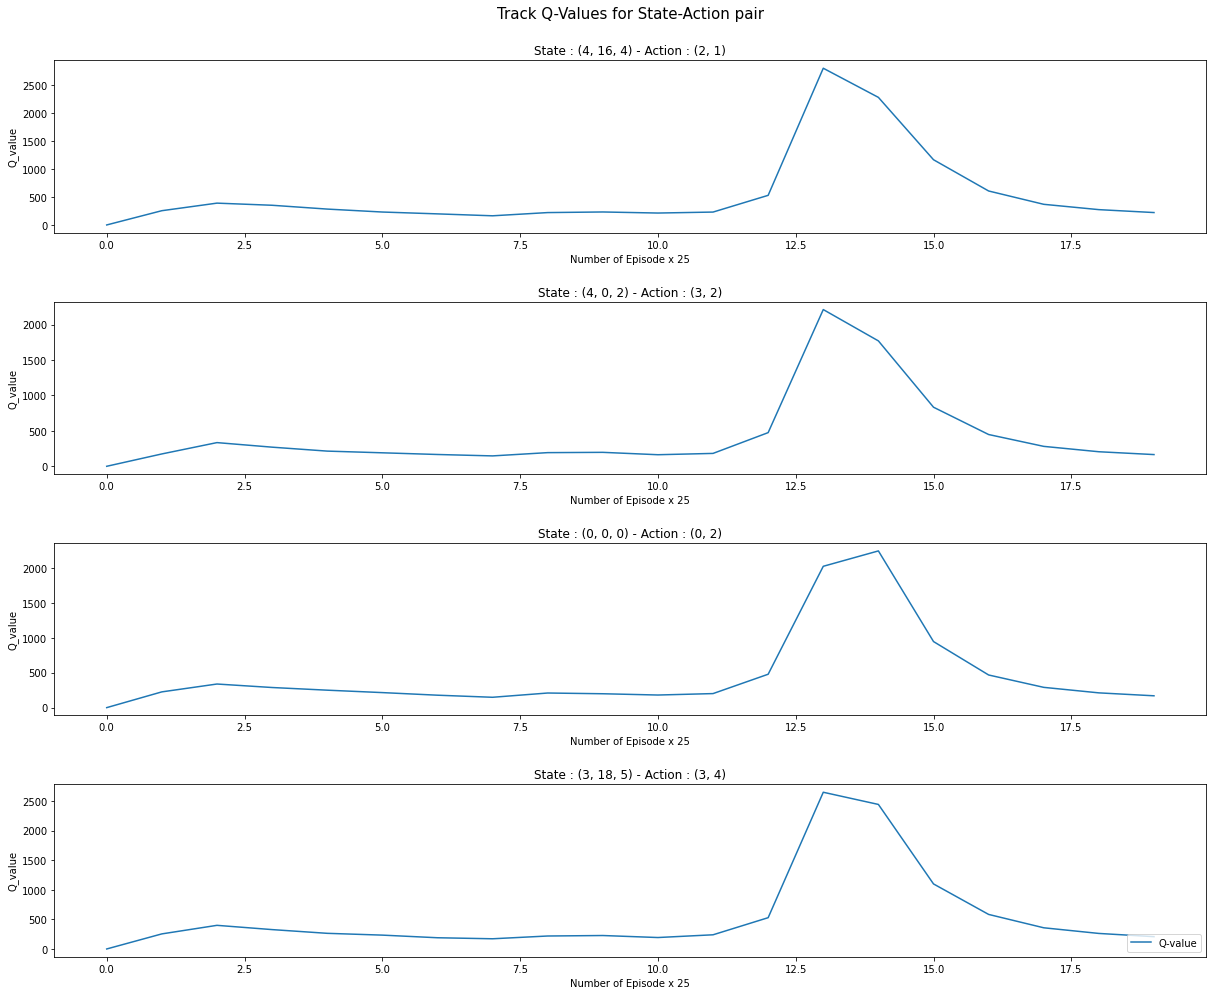

In [14]:
# create a subplot
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 15))
fig.tight_layout()

# iterate over the sample q-value state-action pair
for i , state_action in enumerate(states_tracked_plotting):
    # plot the graph
    convergence_plot(state_action[0], state_action[1],axes[i])

# adjust the grid for the subplot for spacing
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.4, 
                    hspace=0.4);

# plot the title
plt.suptitle("Track Q-Values for State-Action pair",fontsize=15)
plt.show();

### REWARDS

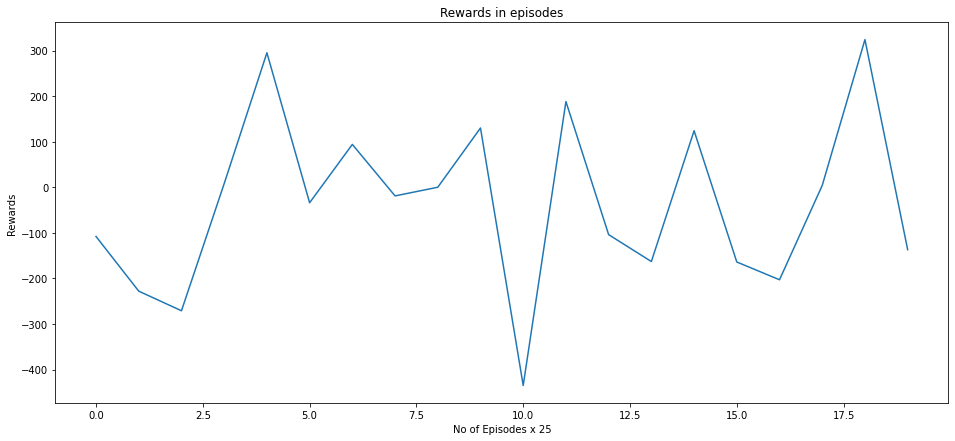

In [15]:
# size figure size
plt.figure(0, figsize=(16,7))

# assign the rewards data to y
y_rewards = reward_val_per_episode
x_len = list(range(0, len(y_rewards)))

# plot the relation for rewards and episode #
plt.plot(x_len,y_rewards)
plt.title('Rewards in episodes')
plt.ylabel("Rewards")
plt.xlabel("No of Episodes x 25")
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

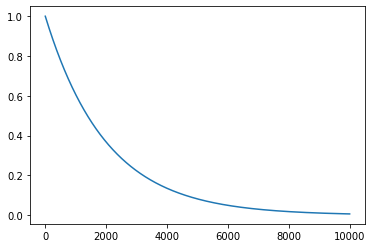

In [16]:
# Epsilon-decay logic 
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0.00001 + (1 - 0.00001) * np.exp(-0.0005*i))
plt.plot(time, epsilon)
plt.show()